# Assignment 5 - Bayesian Methods
by Bryan Carr
13 June 2022
for AAI 510
University of San Diego


In this assignment, we will aim to use Bayesian statistical methods to improve our earlier model. We are once again using the Home Credit dataset from Kaggle.com:
https://www.kaggle.com/competitions/home-credit-default-risk/data

Recall in Assignment 4 that two reasonable models were created:
1) A Random Forest with n=100 estimators; Max Depth = 20; min_samples_split = 10; and 50x weighting for the Positive target class
-- this model had Test Accuracy of 62.7% and Test Recall of 71.7%
2) A XGB gradient-boosted forest with n=75, Max Depth = 11, and 50x Weighting
-- this model had Test Accuracy of 68.3% and Test Recall of 60.6%

Today we will aim to create a predictive variable based on the dataset's included loan history, to predict whether or not an applicant has a history of difficulty making payments.

In [239]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB


In [240]:
# read in Application data
application_df = pd.read_csv('data/application_train.csv')

In [241]:
application_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


As before, we will drop the Building Information columns from the middle of the dataframe. Let's check their indices, then drop them, then verify.

In [242]:
application_df.columns[44:91]

Index(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_M

In [243]:
application_df.drop(axis='columns', columns=application_df.columns[44:91], inplace=True)

In [244]:
# ALso drop Name_Type_Suite for the type of accompaniment, which we are not using
application_df.drop(axis=1, columns='NAME_TYPE_SUITE', inplace=True)


In [245]:
application_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


We can safely fill in the 'Unknown' for Null values of Occupation_Type as well, without leaking any data into our future test splt.

In [246]:
application_df['OCCUPATION_TYPE'].mask(application_df['OCCUPATION_TYPE'].isnull(), 'Unknown', inplace=True)

In [247]:
application_df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 74, dtype: int64

In [248]:
# read in Past Loan Balance data
past_balance_df = pd.read_csv('data/POS_CASH_balance.csv')

In [249]:
past_balance_df.head(20)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


In [250]:
past_balance_df.shape

(10001358, 8)

In [251]:
past_balance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [252]:
# Check number of unique participants in Past Balance DF, based on Current Loan ID
past_balance_df['SK_ID_CURR'].nunique()


337252

In [253]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_INCOME_TYPE             307511 non-null  object 
 12  NAME_EDUCATION_TYPE          307511 non-null  object 
 13 

In [254]:
# Check number of loans in Application_DF
application_df['SK_ID_CURR'].nunique()


307511

## 1.1 - Building a Target Variable for Past Loans

I want to identify if an applicant has a history of loans being past due, as this seems like a strong indicator. I'll build this varialbe from the Past_Balance data, which has columns for Days-Past-Due and Days-Past-Due for Larger loans (exempting some small loans within a tolerance). I'll pick the later to base off of, as it uses some prior knowledge of the credit agency (some loan payments are small and ignorable).

In [255]:
# Check counts of entries in Past Balance's Days-Past-Due columns
past_balance_df['SK_DPD'].value_counts()


0       9706131
1         21872
2         17358
3         14403
4         12350
         ...   
3278          1
3280          1
3282          1
3284          1
4231          1
Name: SK_DPD, Length: 3400, dtype: int64

In [256]:
"""
Function: Make_Row_Target

Returns a value of 1.0 (i.e. Target == True) if the target column (SK_DPD_DEF) is greater than 0
i.e. if a loan is past due (outside of tolerance for small loans)

Otherwise returns a 0.0 (i.e. loan is not past due)

To be used row-wise in creating a new Target column
"""

def make_row_target(row):
    if row['SK_DPD_DEF'] > 0:
        return 1.0
    else:
        return 0.0


In [257]:
# Apply the above function to our Past_Balance DF to
past_balance_df['Past_Due'] = past_balance_df.apply(lambda row: make_row_target(row), axis=1)

In [258]:
# Check on the new dataframe
past_balance_df

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,Past_Due
0,1803195,182943,-31,48.0,45.0,Active,0,0,0.0
1,1715348,367990,-33,36.0,35.0,Active,0,0,0.0
2,1784872,397406,-32,12.0,9.0,Active,0,0,0.0
3,1903291,269225,-35,48.0,42.0,Active,0,0,0.0
4,2341044,334279,-35,36.0,35.0,Active,0,0,0.0
...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0,0.0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0,0.0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0,0.0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0,0.0


In [259]:
past_balance_df['Past_Due'].value_counts()

0.0    9887389
1.0     113969
Name: Past_Due, dtype: int64

In [260]:
past_balance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
 8   Past_Due               float64
dtypes: float64(3), int64(5), object(1)
memory usage: 686.7+ MB


## 1.2 - Building our Predictive Data

Now that we have a variable to predict on -- are late payments made? -- we need to find some fair data to make our predictions from. The Past_Balance dataframe doesn't offer much. Nor would the Installment_Payments file, which would only tell us if payments are late. We'll need to use the data in the Previous_Application file, which contains generalities about loans. I'll begin by loading that data in and looking at the dataframe -- we won't want to use all the columns for our Bayesian prediction, as some will be red herrings with little use.

In [261]:
previous_app_df = pd.read_csv('data/previous_application.csv')

In [262]:
previous_app_df.head(20)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [263]:
previous_app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

We can drop a few variables of less likely importance: Weekday & Hour of Application; the Flags, and the Rates (which are too full of Nulls, and should be accounted for in the Amt_Credit and Amt_Annuity). Name_Type_Suite is not being used and can also be dropped.

Many of the categorical columns both do not sound like useful information (except for Yield Type), and have many 'XNA' values which appear to be coded Nulls. I will drop those, to simplify the imputation and pipeline.

The last few columns refer to time between this previous loan and the current one (our overall target variable). This info has no bearing on failure to repay the previous loan, and can safely be dropped.

In [264]:
previous_app_drop = previous_app_df.columns[8:26].tolist()
previous_app_drop.append(previous_app_df.columns[2])

In [265]:
previous_app_drop.extend(previous_app_df.columns[26:29].tolist())

In [266]:
previous_app_drop.extend(previous_app_df.columns[30:].tolist())

In [267]:
previous_app_drop

['WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'DAYS_DECISION',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_CONTRACT_TYPE',
 'SELLERPLACE_AREA',
 'NAME_SELLER_INDUSTRY',
 'CNT_PAYMENT',
 'PRODUCT_COMBINATION',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

In [268]:
previous_app_df.drop(axis=1, columns=previous_app_drop, inplace=True)

In [269]:
previous_app_df.head(20)

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,NAME_YIELD_GROUP
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,middle
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,low_action
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,high
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,middle
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,high
5,1383531,199383,23703.930,315000.0,340573.5,NaN,315000.0,low_normal
6,2315218,175704,NaN,0.0,0.0,NaN,NaN,XNA
7,1656711,296299,NaN,0.0,0.0,NaN,NaN,XNA
8,2367563,342292,NaN,0.0,0.0,NaN,NaN,XNA
9,2579447,334349,NaN,0.0,0.0,NaN,NaN,XNA


In [270]:
previous_app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   SK_ID_PREV        1670214 non-null  int64  
 1   SK_ID_CURR        1670214 non-null  int64  
 2   AMT_ANNUITY       1297979 non-null  float64
 3   AMT_APPLICATION   1670214 non-null  float64
 4   AMT_CREDIT        1670213 non-null  float64
 5   AMT_DOWN_PAYMENT  774370 non-null   float64
 6   AMT_GOODS_PRICE   1284699 non-null  float64
 7   NAME_YIELD_GROUP  1670214 non-null  object 
dtypes: float64(5), int64(2), object(1)
memory usage: 101.9+ MB


Amt_Income is one of the most important variables. We will need to add this in from the Current Loan Application dataframe in order to use it (acknowledging that the applicant's income may have changed -- this is the best we can do for now). We can do an Inner join, in case there are any previous loans without current applicants' incomes (which would be useless to predict on).

In [271]:
previous_pred_df = previous_app_df.join(application_df['AMT_INCOME_TOTAL'], on='SK_ID_CURR', how='inner')

In [272]:
predict_df = previous_pred_df.join(past_balance_df['Past_Due'], on='SK_ID_PREV', how='left')

In [273]:
predict_df

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,NAME_YIELD_GROUP,AMT_INCOME_TOTAL,Past_Due
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,middle,135000.0,0.0
735737,1696966,271877,68258.655,1800000.0,1754721.0,180000.0,1800000.0,low_normal,135000.0,0.0
1567518,2154916,271877,12417.390,108400.5,119848.5,0.0,108400.5,middle,135000.0,0.0
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,low_action,180000.0,0.0
335841,1536272,108129,21709.125,450000.0,512370.0,NaN,450000.0,low_normal,180000.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1669427,1563733,227766,13726.080,137250.0,123525.0,13725.0,137250.0,low_normal,90000.0,1.0
1669619,2319569,239799,4716.495,46800.0,46800.0,0.0,46800.0,middle,74250.0,0.0
1669655,2210917,174832,30439.305,243000.0,289732.5,NaN,243000.0,middle,135000.0,0.0
1669726,2253728,253940,26084.700,135000.0,135000.0,0.0,135000.0,high,76500.0,0.0


In [274]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971102 entries, 0 to 1670060
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SK_ID_PREV        971102 non-null  int64  
 1   SK_ID_CURR        971102 non-null  int64  
 2   AMT_ANNUITY       754609 non-null  float64
 3   AMT_APPLICATION   971102 non-null  float64
 4   AMT_CREDIT        971102 non-null  float64
 5   AMT_DOWN_PAYMENT  450226 non-null  float64
 6   AMT_GOODS_PRICE   746765 non-null  float64
 7   NAME_YIELD_GROUP  971102 non-null  object 
 8   AMT_INCOME_TOTAL  971102 non-null  float64
 9   Past_Due          971102 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 81.5+ MB


We can see there are a number of nulls in Amt_Annuity (which should not be zero), Amt_Down_Payment (which could be zero for all we know), and Amt_Goods_Price (again, should not be zero). It would be nice to use Iterative Imputer on these to fill in based on nearby columns.

We do not need to transform the categorical data as the Naive Bayes algorithm handles categorical data well.

Let's make the necessary transformers:

In [275]:
# List out Numeric Columns for a Column Transformer
num_cols_predict = ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'Past_Due']

In [276]:
# Build Iterative Imputer
numeric_transformer_predict = Pipeline(steps=[
    ('imputer', IterativeImputer(verbose=1, random_state=123,
                                 estimator=BayesianRidge(lambda_init=0.1),
                                 missing_values=np.nan,
                                 n_nearest_features=5, # do multi regression on only up to 5 features
                                 initial_strategy='mean' # initially set imputes to the Mean
                                 ))
])

In [277]:
# Build Categorical OHE transformer
categ_transformer = Pipeline(steps=[
    ('OneHot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [278]:
# Make Column Transformer, passing through the remainders (IDs)
col_transformer_predict = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer_predict, num_cols_predict),
        ('ohe', categ_transformer, ['NAME_YIELD_GROUP'])
    ],
    remainder='passthrough'
)

In [279]:
predict_array_transformed=[]
predict_array_transformed = col_transformer_predict.fit_transform(predict_df)


[IterativeImputer] Completing matrix with shape (971102, 7)
[IterativeImputer] Change: 1274384.4338942694, scaled tolerance: 18000.09 
[IterativeImputer] Change: 11684.193503930728, scaled tolerance: 18000.09 
[IterativeImputer] Early stopping criterion reached.


In [280]:
predict_array_transformed

array([[1.73043000e+03, 1.71450000e+04, 1.71450000e+04, ...,
        1.00000000e+00, 2.03049500e+06, 2.71877000e+05],
       [6.82586550e+04, 1.80000000e+06, 1.75472100e+06, ...,
        0.00000000e+00, 1.69696600e+06, 2.71877000e+05],
       [1.24173900e+04, 1.08400500e+05, 1.19848500e+05, ...,
        1.00000000e+00, 2.15491600e+06, 2.71877000e+05],
       ...,
       [3.04393050e+04, 2.43000000e+05, 2.89732500e+05, ...,
        1.00000000e+00, 2.21091700e+06, 1.74832000e+05],
       [2.60847000e+04, 1.35000000e+05, 1.35000000e+05, ...,
        0.00000000e+00, 2.25372800e+06, 2.53940000e+05],
       [7.23439996e+03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.94403400e+06, 1.91629000e+05]])

In [281]:
# Converting our array to a Dataframe
# Using Placeholder labels for the One-Hot variables, which are derived from Name_Yield_Group, the broad grouping of yields
predict_df_transformed = pd.DataFrame(predict_array_transformed,
                                      columns=num_cols_predict + ['OHE7','OHE8','OHE9','OHE10','OHE11','SK_ID_PREV', 'SK_ID_CURR'])

In [282]:
# Check our data. It should be ready to go for our Naive Bayes algo now
predict_df_transformed


,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,Past_Due,OHE7,OHE8,OHE9,OHE10,OHE11,SK_ID_PREV,SK_ID_CURR
0,1730.430000,17145.0,17145.0,0.000000,1.714500e+04,135000.0,0.0,0.0,0.0,0.0,0.0,1.0,2030495.0,271877.0
1,68258.655000,1800000.0,1754721.0,180000.000000,1.800000e+06,135000.0,0.0,0.0,0.0,0.0,1.0,0.0,1696966.0,271877.0
2,12417.390000,108400.5,119848.5,0.000000,1.084005e+05,135000.0,0.0,0.0,0.0,0.0,0.0,1.0,2154916.0,271877.0
3,25188.615000,607500.0,679671.0,-26304.921258,6.075000e+05,180000.0,0.0,0.0,0.0,1.0,0.0,0.0,2802425.0,108129.0
4,21709.125000,450000.0,512370.0,-26369.013679,4.500000e+05,180000.0,0.0,0.0,0.0,0.0,1.0,0.0,1536272.0,108129.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971097,13726.080000,137250.0,123525.0,13725.000000,1.372500e+05,90000.0,1.0,0.0,0.0,0.0,1.0,0.0,1563733.0,227766.0
971098,4716.495000,46800.0,46800.0,0.000000,4.680000e+04,74250.0,0.0,0.0,0.0,0.0,0.0,1.0,2319569.0,239799.0
971099,30439.305000,243000.0,289732.5,-25885.926125,2.430000e+05,135000.0,0.0,0.0,0.0,0.0,0.0,1.0,2210917.0,174832.0
971100,26084.700000,135000.0,135000.0,0.000000,1.350000e+05,76500.0,0.0,0.0,1.0,0.0,0.0,0.0,2253728.0,253940.0


In [283]:
# Check the DF for Nulls
predict_df_transformed.isnull().sum()


AMT_ANNUITY         0
AMT_APPLICATION     0
AMT_CREDIT          0
AMT_DOWN_PAYMENT    0
AMT_GOODS_PRICE     0
AMT_INCOME_TOTAL    0
Past_Due            0
OHE7                0
OHE8                0
OHE9                0
OHE10               0
OHE11               0
SK_ID_PREV          0
SK_ID_CURR          0
dtype: int64

## 1.3 - Building our Naive Bayes Model

We will now build the Naive Bayes model to predict if a loan payment will be Past Due based on our selected data from previous loan applications.

In [284]:
gnb = GaussianNB()

In [285]:
# Split off X and Y
X_predict = predict_df_transformed.drop(columns=['Past_Due', 'SK_ID_CURR', 'SK_ID_PREV'])
X_predict


,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,OHE7,OHE8,OHE9,OHE10,OHE11
0,1730.430000,17145.0,17145.0,0.000000,1.714500e+04,135000.0,0.0,0.0,0.0,0.0,1.0
1,68258.655000,1800000.0,1754721.0,180000.000000,1.800000e+06,135000.0,0.0,0.0,0.0,1.0,0.0
2,12417.390000,108400.5,119848.5,0.000000,1.084005e+05,135000.0,0.0,0.0,0.0,0.0,1.0
3,25188.615000,607500.0,679671.0,-26304.921258,6.075000e+05,180000.0,0.0,0.0,1.0,0.0,0.0
4,21709.125000,450000.0,512370.0,-26369.013679,4.500000e+05,180000.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
971097,13726.080000,137250.0,123525.0,13725.000000,1.372500e+05,90000.0,0.0,0.0,0.0,1.0,0.0
971098,4716.495000,46800.0,46800.0,0.000000,4.680000e+04,74250.0,0.0,0.0,0.0,0.0,1.0
971099,30439.305000,243000.0,289732.5,-25885.926125,2.430000e+05,135000.0,0.0,0.0,0.0,0.0,1.0
971100,26084.700000,135000.0,135000.0,0.000000,1.350000e+05,76500.0,0.0,1.0,0.0,0.0,0.0


In [286]:
# Create the Y Data, Past_Due
Y_predict = predict_df_transformed['Past_Due']
Y_predict[Y_predict == 1.0]

66        1.0
137       1.0
236       1.0
512       1.0
726       1.0
         ... 
970543    1.0
970936    1.0
970949    1.0
970972    1.0
971097    1.0
Name: Past_Due, Length: 10402, dtype: float64

In [287]:
gnb.fit(X_predict, Y_predict)

GaussianNB()

In [288]:
# Check the accuracy for our new model
gnb.score(X_predict,Y_predict)


0.9892153450409946

In [289]:
# The accuracy looks good, at ~99%. Let's look at the Probabilities -- this is what we want to generate as a variable
gnb.predict_proba(X_predict)[1110]

array([0.9882482, 0.0117518])

In [290]:
# Check for a baseline accuracy: Count of Past_Due vs Total Count.
1- (Y_predict.sum() / Y_predict.count())


0.9892884578550966

In [291]:
# CHeck the COnfusion Matrix
confusion_matrix(Y_predict, gnb.predict(X_predict))


array([[960626,     74],
       [ 10399,      3]], dtype=int64)

We can see that this Gaussian Naive Bayes is quite bad at actually making predictions, as it is just strongly predicting negatives in this imbalanced dataset. We should try something else.

SKLearn has a ComplementNB Classifier which is supposed to be better for imbalanced datasets. Let's try it.

CNB requires nonzero data, so the first step will be to apply a Min-Max Scaler to our dataframe, to scale the data between 0 and 1.

In [292]:
# Create a scaler with the default range of 0 to 1
min_max_scaler = MinMaxScaler()


In [293]:
X_predict_scaled = min_max_scaler.fit_transform(X_predict)
X_predict_scaled

array([[0.00413921, 0.00384848, 0.00417727, ..., 0.        , 0.        ,
        1.        ],
       [0.16327551, 0.4040404 , 0.42752703, ..., 0.        , 1.        ,
        0.        ],
       [0.02970254, 0.02433232, 0.02920035, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.07281118, 0.05454545, 0.07059155, ..., 0.        , 0.        ,
        1.        ],
       [0.06239491, 0.03030303, 0.03289192, ..., 0.        , 0.        ,
        0.        ],
       [0.01730477, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [294]:
# Create the CNB model object
cnb = ComplementNB()

In [295]:
# Fit the model on our data
cnb.fit(X_predict_scaled, Y_predict)

ComplementNB()

In [296]:
# Check the Confusion Matrix
confusion_matrix(Y_predict, cnb.predict(X_predict_scaled))


array([[535328, 425372],
       [  5675,   4727]], dtype=int64)

In [297]:
cnb.predict(X_predict_scaled)

array([1., 0., 1., ..., 1., 1., 0.])

In [298]:
cnb.score(X_predict_scaled, Y_predict)

0.5561259270395901

In [299]:
cnb.predict_proba(X_predict_scaled)

array([[0.49337278, 0.50662722],
       [0.50902146, 0.49097854],
       [0.49325395, 0.50674605],
       ...,
       [0.49305777, 0.50694223],
       [0.49376243, 0.50623757],
       [0.50251502, 0.49748498]])

This seems like quite poor and indeterminate performance, but let's give it a try. Maybe these new probabilities will help in our XGBoost model.

To do so, we must create a DF which we can Join onto the initial Application_DF, i.e. which has the SK_ID_CURR variable. We will need to average out the scores for repeated previous entries.

In [300]:
cnb_prediction_df = pd.DataFrame(cnb.predict_proba(X_predict_scaled))
cnb_prediction_df.columns = ['Probab_0', 'Probab_1']
cnb_prediction_df = cnb_prediction_df.join(predict_df_transformed['SK_ID_CURR'])
cnb_prediction_df

,Probab_0,Probab_1,SK_ID_CURR
0,0.493373,0.506627,271877.0
1,0.509021,0.490979,271877.0
2,0.493254,0.506746,271877.0
3,0.505013,0.494987,108129.0
4,0.509718,0.490282,108129.0
...,...,...,...
971097,0.509877,0.490123,227766.0
971098,0.493356,0.506644,239799.0
971099,0.493058,0.506942,174832.0
971100,0.493762,0.506238,253940.0


In [301]:
cnb_groups = cnb_prediction_df.groupby('SK_ID_CURR')

In [302]:
cnb_groups.mean()

,Probab_0,Probab_1
SK_ID_CURR,,
100001.0,0.493698,0.506302
100002.0,0.509905,0.490095
100003.0,0.498321,0.501679
100004.0,0.493343,0.506657
100005.0,0.498263,0.501737
...,...,...
307506.0,0.497939,0.502061
307507.0,0.496880,0.503120
307508.0,0.493955,0.506045


In [303]:
application_df['SK_ID_CURR']

0         100002
1         100003
2         100004
3         100006
4         100007
           ...  
307506    456251
307507    456252
307508    456253
307509    456254
307510    456255
Name: SK_ID_CURR, Length: 307511, dtype: int64

In [304]:
model_df = application_df.join(cnb_groups.mean(), on='SK_ID_CURR', how='left')

In [305]:
model_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Probab_0,Probab_1
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.509905,0.490095
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.498321,0.501679
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.493343,0.506657
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.501116,0.498884
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.493569,0.506431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [306]:
# Check for Nulls:
model_df.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
                               ...  
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Probab_0                      138149
Probab_1                      138149
Length: 76, dtype: int64

In [307]:
# Drop rows with nulls in our predictive variable, as they are too unreliable
# Recall that we also dropped nulls in the AMT_REQ_CREDIT_BUREAU columns - we will repeat that here
#model_df.dropna(axis=0, subset=['Probab_0', 'Probab_1', 'AMT_REQ_CREDIT_BUREAU_DAY'], inplace=True)


model_df.dropna(axis=0, subset=['AMT_REQ_CREDIT_BUREAU_DAY'], inplace=True)

## 3.1 - Splitting and Pre-Processing before XGBoost

We are now ready to rebuild the previous XGBoost model, with these two new 'Bayesian Prediction' variables.

First we will need to pre-process the Application data. Recall that we need to fill OWN_CAR_AGE and replace the outlier in DAYS_EMPLOYED. Then do some One Hot Encoding, and finally apply our Iterative Imputer to fill in any remaining blanks.

In [308]:
# Split off the X and Y variables, starting with X

X_final = model_df.drop(columns=['SK_ID_CURR', 'TARGET'])
Y_final = model_df['TARGET']

In [309]:
# Create testing split of 20% size

X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size=0.2, random_state=123)

In [310]:
# Filling in OWN_CAR_AGE
X_train['OWN_CAR_AGE'].fillna(value=(-2 * X_train.std()['OWN_CAR_AGE']), inplace=True)

# repeat on Test, with the Training data's values to not leak info
X_test['OWN_CAR_AGE'].fillna(value=(-2 * X_train.std()['OWN_CAR_AGE']), inplace=True)

C:\Users\bcarr\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [311]:
# Replacing the Outliers in DAYS_EMPLOYED
# We used 5000, or approx 2* Std_Dev.

X_train['DAYS_EMPLOYED'].mask(X_train['DAYS_EMPLOYED'] > 1, 5000.0, inplace=True)

#Repeat the transformation for the Test Set
X_test['DAYS_EMPLOYED'].mask(X_test['DAYS_EMPLOYED'] > 1, 5000.0, inplace=True)

C:\Users\bcarr\anaconda3\lib\site-packages\pandas\core\generic.py:9004: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
C:\Users\bcarr\anaconda3\lib\site-packages\pandas\core\generic.py:9004: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(


In [312]:
# Review column names in the data
X_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Probab_0,Probab_1
53753,Cash loans,M,N,Y,0,180000.0,730017.0,35248.5,652500.0,Working,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.497426,0.502574
12882,Cash loans,F,Y,Y,0,98100.0,284400.0,16456.5,225000.0,Pensioner,...,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.497941,0.502059
248472,Cash loans,M,N,Y,0,225000.0,835380.0,42840.0,675000.0,Working,...,0,0,0.0,0.0,0.0,1.0,0.0,5.0,NaN,NaN
270818,Cash loans,M,N,N,0,225000.0,755190.0,32125.5,675000.0,Working,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
101771,Revolving loans,M,N,Y,1,189000.0,270000.0,13500.0,270000.0,Commercial associate,...,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.502151,0.497849


In [313]:
#Define columns for transformer
#Remember that the Document fields are already binary and full, so no more pre-processing is needed
# We will pass through our Probability data variables, and not run the Iterative imputer on it, as it is new to the model. I am lacking some confidence in it at this point
binary_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categ_cols = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
              'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
numeric_cols = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [314]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', IterativeImputer(verbose=1, random_state=123,
                                 estimator=BayesianRidge(lambda_init=0.1),
                                 missing_values=np.nan,
                                 n_nearest_features=5, # do multi regression on only up to 5 features
                                 initial_strategy='mean' # initially set imputes to the Mean
                                 ))
])

In [315]:
# Make Binary Cols Pipeline
binary_transformer = Pipeline(steps=[
    ('OHE', OneHotEncoder(drop='if_binary', sparse=False))
])

In [316]:
# Make Categorical Cols Pipeline
categ_transformer = Pipeline(steps=[
    ('OneHot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [317]:
col_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categ_transformer, categ_cols),
        ('binary', binary_transformer, binary_cols)
    ],
    remainder='passthrough'
)

In [318]:
# Fit_Transform the Transformer on X_Train
X_train_preprocessed = col_transformer.fit_transform(X_train)

[IterativeImputer] Completing matrix with shape (212793, 29)
[IterativeImputer] Change: 2.588588299494135, scaled tolerance: 0.42792632180369294 
[IterativeImputer] Change: 1.1563885692028615, scaled tolerance: 0.42792632180369294 
[IterativeImputer] Change: 2.343966308163636, scaled tolerance: 0.42792632180369294 
[IterativeImputer] Change: 2.5694602892500624, scaled tolerance: 0.42792632180369294 
[IterativeImputer] Change: 2.394765239663136, scaled tolerance: 0.42792632180369294 
[IterativeImputer] Change: 3.0358950519819485, scaled tolerance: 0.42792632180369294 
[IterativeImputer] Change: 3.5662010569691045, scaled tolerance: 0.42792632180369294 
[IterativeImputer] Change: 4.167697741377685, scaled tolerance: 0.42792632180369294 
[IterativeImputer] Change: 3.539910199111387, scaled tolerance: 0.42792632180369294 
[IterativeImputer] Change: 2.51684420600181, scaled tolerance: 0.42792632180369294 


C:\Users\bcarr\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [319]:
# Apply the transformer to the Test Data
X_test_preprocessed = col_transformer.transform((X_test))

[IterativeImputer] Completing matrix with shape (53199, 29)


In [320]:
# Take a look at X_train:
X_train_preprocessed

array([[-0.58295853,  0.03106024,  0.30388725, ...,  0.        ,
         0.49742587,  0.50257413],
       [-0.58295853, -0.26892796, -0.79472299, ...,  0.        ,
         0.4979406 ,  0.5020594 ],
       [-0.58295853,  0.19588892,  0.5636459 , ...,  0.        ,
                nan,         nan],
       ...,
       [-0.58295853,  0.27830327,  0.27919165, ...,  0.        ,
         0.49338783,  0.50661217],
       [-0.58295853, -0.29859712,  0.49774659, ...,  0.        ,
         0.49885515,  0.50114485],
       [-0.58295853, -0.33156286, -0.27587134, ...,  0.        ,
                nan,         nan]])

## 3.2 Applying our XGBoost model to the data

It is finally time to rebuild our model and apply it to our data.

Recall that for the 'Short' XGB tree, we had a superior recall & confusion matrix. So we will use those hyperparameters.

Recall that the scores were:

In [321]:
past_training_acc = 0.7636743803594502
past_training_recall = 0.9999392577294539
past_testing_acc = 0.6833374085428932
past_testing_recall = 0.6061425061425061

In [322]:
past_testing_confusion_matrix = np.array([[33864, 15233],
                                          [ 1603,  2467]])

In [323]:
# I also want to compare F1 scores on Testing, so will need to compute the Precision from the above Confusion Matrix
past_testing_precision = past_testing_confusion_matrix[1][1] / (past_testing_confusion_matrix[1][1] + past_testing_confusion_matrix[0][1])
past_testing_precision

0.13937853107344633

In [324]:
past_testing_f1 = 2 * (past_testing_recall * past_testing_precision) / (past_testing_recall + past_testing_precision)
past_testing_f1

0.22664216812126778

In [325]:
# Build the Model
xgb_class_short = XGBClassifier(
    n_estimators = 75,
    max_depth = 11,
    verbosity = 2,
    n_jobs = -1,
    random_state = 123,
    scale_pos_weight = 50,
)

In [326]:
# Fit the model
xgb_class_short.fit(X_train_preprocessed, Y_train)

C:\Users\bcarr\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:11:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 1232 extra nodes, 0 pruned nodes, max_depth=11
[22:11:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 1124 extra nodes, 0 pruned nodes, max_depth=11
[22:11:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 1266 extra nodes, 0 pruned nodes, max_depth=11
[22:11:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 1088 extra nodes, 0 pruned nodes, max_dep

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=11, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=75, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=50, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=2)

In [327]:
new_train_accuracy = xgb_class_short.score(X_train_preprocessed,Y_train)
new_train_accuracy

0.7673090750165654

In [328]:
new_train_recall = recall_score(Y_train, xgb_class_short.predict(X_train_preprocessed))
new_train_recall

1.0

In [329]:
# Now score Accuracy, Recall and F1 for the Test data
new_test_acc = xgb_class_short.score(X_test_preprocessed, Y_test)
new_test_acc

0.6854640124814376

In [330]:
new_test_recall = recall_score(Y_test, xgb_class_short.predict(X_test_preprocessed))
new_test_recall

0.5869565217391305

In [331]:
new_test_f1 = f1_score(Y_test, xgb_class_short.predict(X_test_preprocessed))
new_test_f1

0.22507294030472838

In [332]:
# Lastly let's look at the Testing Confusion Matrix
new_test_confusion_matrix = confusion_matrix(Y_test, xgb_class_short.predict(X_test_preprocessed))
new_test_confusion_matrix

array([[34036, 15023],
       [ 1710,  2430]], dtype=int64)

In [333]:
# Compare to the old model's confusion matrix, which provided better scores
past_testing_confusion_matrix

array([[33864, 15233],
       [ 1603,  2467]])

In [334]:
# Count the values in the old testing data:
past_testing_confusion_matrix.sum()

53167

In [335]:
# Count of values in the new testing data:
new_test_confusion_matrix.sum()

53199

## 4. Discussion

We can see that, despite our efforts, our scores have not significantly changed. If anything, they are slightly worse in terms of Recall and F1.

The testing scores before adding Bayes:
Accuracy = 68.3%
Recall = 60.6%
F1 = 22.6%

And after:
Accuracy = 68.5%
Recall = 58.7%
F1 = 22.1%

We should check the Feature Importance to see where our added Bayesian features rank

In [336]:
# Find the location of our variables -- they were passed through
X_test_preprocessed

array([[-0.58295853, -0.0513541 , -0.12277194, ...,  0.        ,
         0.50197007,  0.49802993],
       [-0.58295853, -0.29859712,  0.27180294, ...,  0.        ,
         0.49680816,  0.50319184],
       [ 2.17406451, -0.13376844, -0.49739951, ...,  0.        ,
                nan,         nan],
       ...,
       [-0.58295853, -0.13376844,  0.71039944, ...,  0.        ,
         0.50268673,  0.49731327],
       [ 3.55257603, -0.49639154, -1.05210749, ...,  0.        ,
         0.49398151,  0.50601849],
       [-0.58295853, -0.38101147, -0.94116589, ...,  0.        ,
                nan,         nan]])

In [337]:
# We can see they are features 176 and 177, at the end of the matrix
xgb_class_short.feature_importances_

array([0.00363958, 0.00476721, 0.00615773, 0.00653774, 0.00771266,
       0.00539966, 0.00627272, 0.00618481, 0.00556362, 0.00589299,
       0.00644976, 0.00533205, 0.00468339, 0.00738304, 0.00537823,
       0.00710585, 0.00914989, 0.01140282, 0.00489991, 0.00512376,
       0.00726146, 0.0069605 , 0.00616271, 0.00518416, 0.00554358,
       0.00666717, 0.00642705, 0.00620507, 0.00603605, 0.        ,
       0.0050183 , 0.        , 0.        , 0.00680128, 0.        ,
       0.        , 0.00522338, 0.00704034, 0.01057763, 0.00501708,
       0.00864609, 0.00855834, 0.00410999, 0.00747468, 0.0048098 ,
       0.00426769, 0.        , 0.00642447, 0.00813313, 0.00590658,
       0.00639172, 0.00578343, 0.0050217 , 0.00395034, 0.00711004,
       0.00674237, 0.00570698, 0.00661525, 0.00600676, 0.00649551,
       0.00717378, 0.00545817, 0.00544743, 0.00435866, 0.00625415,
       0.0069034 , 0.00954537, 0.00864807, 0.00468485, 0.00669545,
       0.0063223 , 0.00462845, 0.00543559, 0.00451581, 0.00580

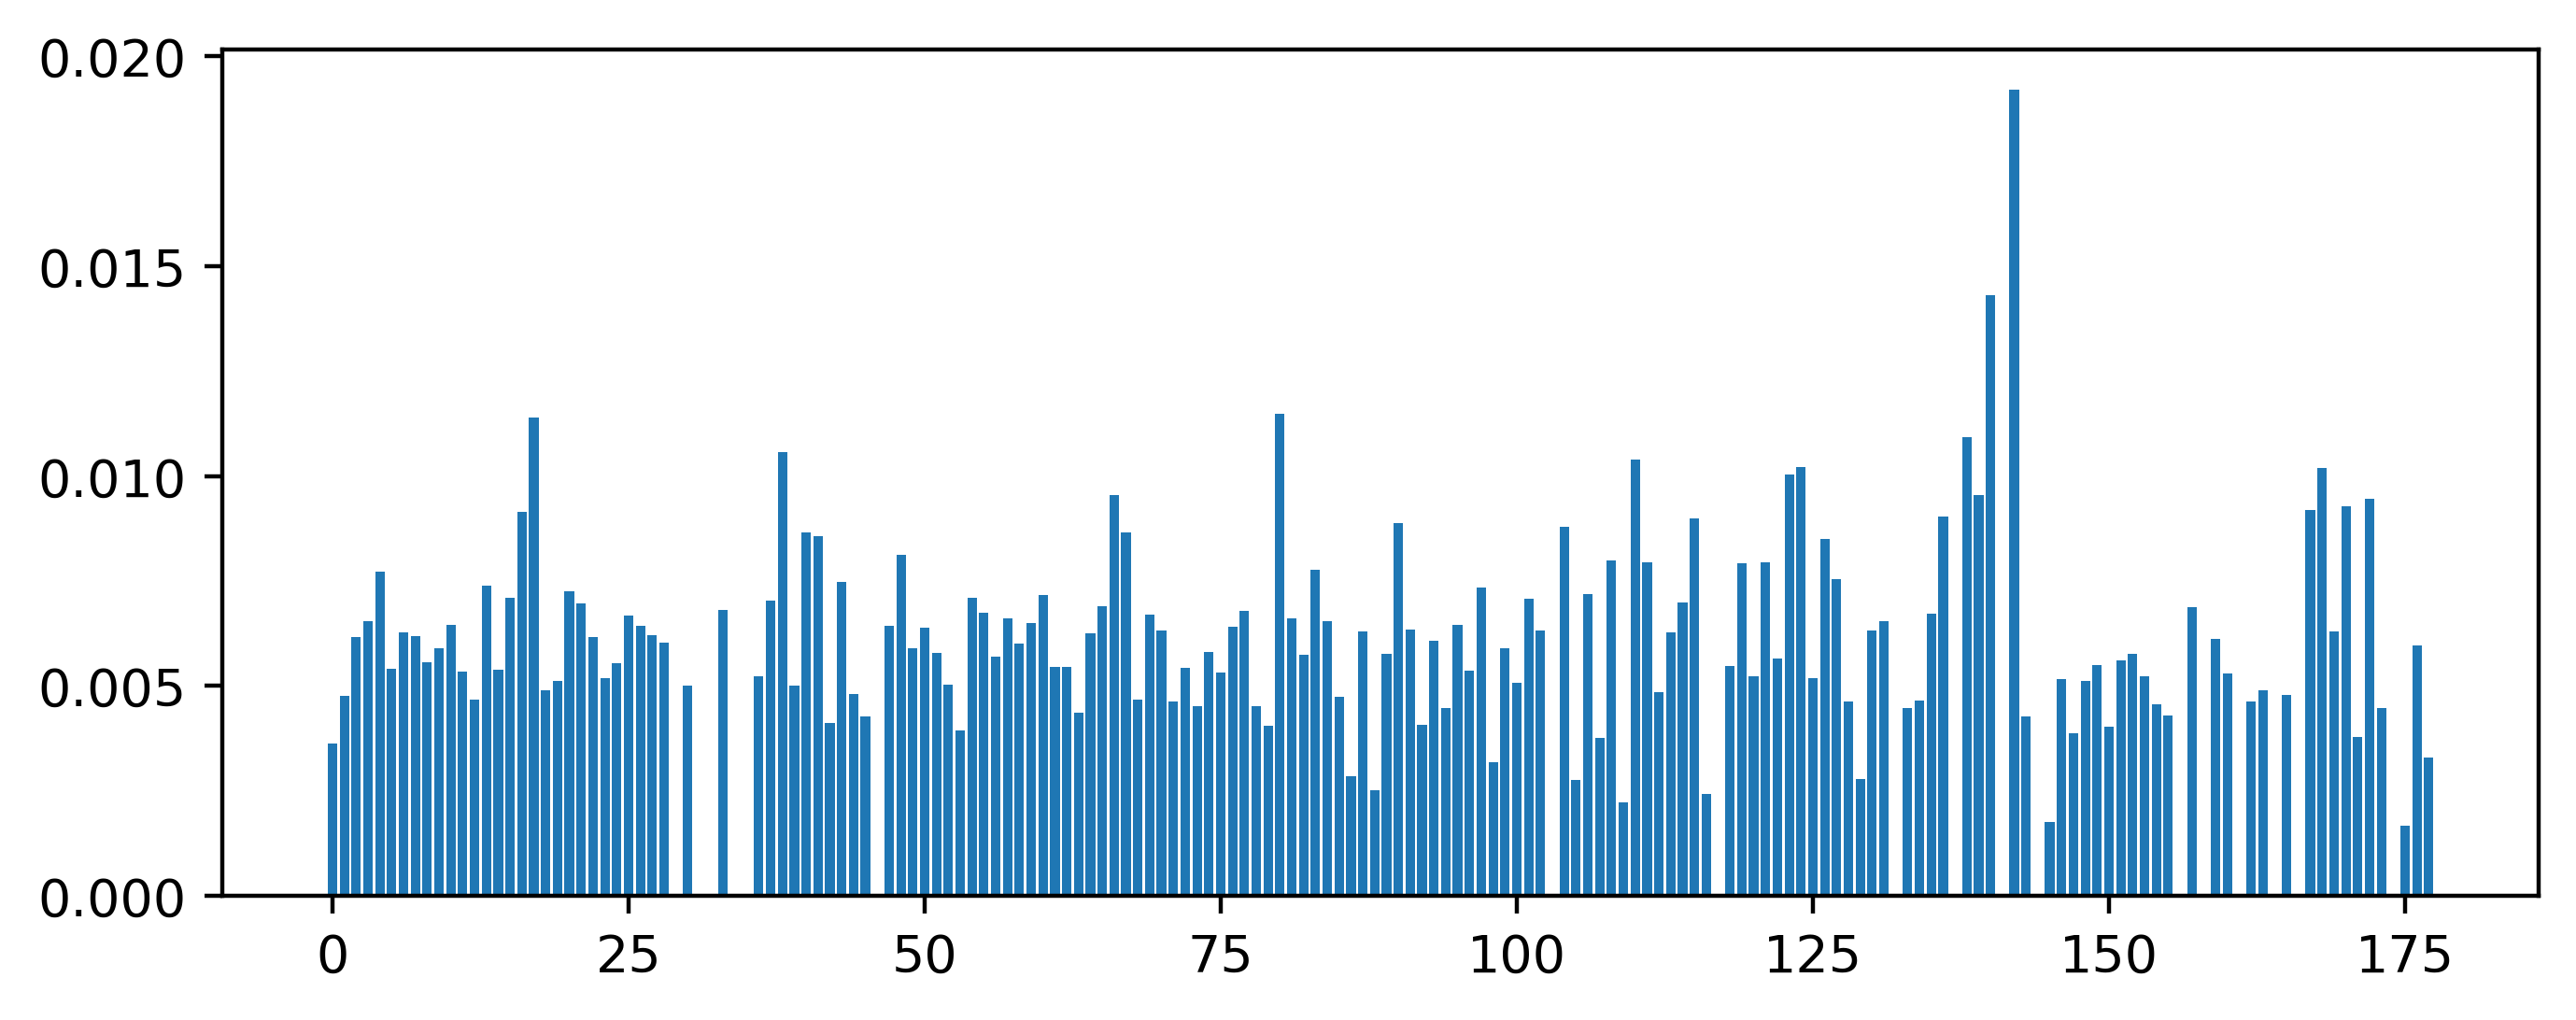

In [338]:
plt.figure(figsize=(8,3), dpi=400)
plt.bar(range(len(xgb_class_short.feature_importances_)), xgb_class_short.feature_importances_)
plt.show()

The Bayesian features are the last ones, 176 and 177. We can see they are both quite low, with a combined score of 0.0059 + 0.0033 = 0.0092.

First, consider that this new feature was not avaialable for every point - there are around 13,000 nulls for it left in the data, where there was no previous history of payments for the current loan applicant. Also recall that we needed to add in the Income data, as the historical data was somewhat sparse. Having better data to make our predictions off of would always help.

Also, consider that the prediction of the original model was quite poor, with an accuracy of around 55% (in particular, it featured far too many false Negative predictions). Our dataset was too imbalanced to be effective with the Gaussian Naive Bayes model. In the future, we should find a more balanced historical dataset to make predictions on - though at the moment this possibility is not obvious to me. It would require some significant consultation with experts to determine what predictions we might want to make, that would be helpful and feasible.